# Leadangle_fitplot4.ipynb

密度のSystem III経度依存性

In [58]:
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [59]:
def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v / vmax, c))
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

whiteblue=generate_cmap(['#000000','#010E5E','#042AA6','#0F7CE0','#1AC7FF','#FFFFFF'])

In [60]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

In [61]:
# 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [62]:
# 定数
r_orbitM = 9.38*RJ   # ORBITAL RADIUS (average) [m] (Bagenal+2015)
r_orbitC = 9.30*RJ   # ORBITAL RADIUS (closest) [m] (Bagenal+2015)
r_orbitF = 9.47*RJ   # ORBITAL RADIUS (farthest) [m] (Bagenal+2015)
MOONRADI = 1.56E+6   # MOON RADIUS [m]
OMG_E = 2.0478E-5    # 衛星の公転角速度 [rad/s]
n0 = 110             # [cm-3] (Cassidy+2013)

ne_1 = 63            # 電子数密度 [cm-3] (Bagenal+2015)
ne_2 = 158           # 電子数密度 [cm-3] (Bagenal+2015)
ne_3 = 290           # 電子数密度 [cm-3] (Bagenal+2015)

Ai = 18              # 平均イオン原子量 (Bagenal+2015)
Zi = 1.4             # 平均イオン価数 [q] (Bagenal+2015)

Ti_14 = 72           # 平均イオン温度 [eV] (Best fit 2014_6)
rho0_14 = 1703       # プラズマ質量密度 [amu cm-3] (Best fit 2014_6)

Ti_22 = 138          # 平均イオン温度 [eV] (Best fit 2022_6)
rho0_22 = 2746       # プラズマ質量密度 [amu cm-3] (Best fit 2022_6)

H_p = 1.8*RJ         # [m]
Hp0 = 0.64*RJ        # 基準スケールハイト [m] (Bagenal&Delamere2011)
wlonN = copy.copy(satovalN.wlon)
FwlonN = copy.copy(satovalN.euwlon)
FlatN = copy.copy(satovalN.eulat)
FwlonS = copy.copy(satovalS.euwlon)
FlatS = copy.copy(satovalS.eulat)

OMGR = OMGJ-OMG_E

In [63]:
# Plasma sheet scale height
Hp_14 = Hp0*math.sqrt(Ti_14/Ai)       # Scale height [m] (Bagenal&Delamere2011)
Hp_22 = Hp0*math.sqrt(Ti_22/Ai)       # Scale height [m] (Bagenal&Delamere2011)

In [64]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 50))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta = 0.5*np.pi-S3lat
phi = 2*np.pi-S3wlon
B = np.zeros(phi.shape)
# Br = np.zeros(phi.shape)
# Btheta = np.zeros(phi.shape)
B_far = np.zeros(phi.shape)
B_close = np.zeros(phi.shape)
for i in range(phi.size):
    x = r_orbitM*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitM*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitM*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitM, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitC*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitC*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitC*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitC, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_close[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitF*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitF*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitF*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitF, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_far[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

In [65]:
# 衛星のトーラス内相対位置
# S3RH座標系の(x, y, z)座標
x0 = r_orbitM*np.cos(phi)
y0 = r_orbitM*np.sin(phi)
z0 = np.zeros(x0.shape)
rvec0 = np.array([x0, y0, z0])

# S3RH で Z軸 の(右ネジ)まわりに-65.8度回転
phiRH0 = math.radians(-65.8)    # Connerney+2020
rvec0 = np.array([
    rvec0[0, :]*math.cos(phiRH0) - rvec0[1, :]*math.sin(phiRH0),
    rvec0[0, :]*math.sin(phiRH0) + rvec0[1, :]*math.cos(phiRH0),
    rvec0[2, :]
])

# S3RH で X軸 の(右ネジ)まわりに-7度回転 -> 遠心力座標系に
TILT0 = math.radians(6.7)
rvec = np.array([
    rvec0[0, :],
    rvec0[1, :]*math.cos(TILT0) - rvec0[2, :]*math.sin(TILT0),
    rvec0[1, :]*math.sin(TILT0) + rvec0[2, :]*math.cos(TILT0)
])

# 遠心力座標系における緯度を計算する
theta_cent = np.arccos(rvec[2, :]/r_orbitM)     # 余緯度 [rad]
lat_cent = np.degrees(0.5*np.pi-theta_cent)     # 緯度 [deg]

# リトリーバル結果

In [66]:
rho14 = np.zeros(S3wlon.size)
rho22 = np.zeros(S3wlon.size)

for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])

    # プラズマ質量密度 rho
    rho14[i] = rho0_14*np.exp(-(S0/Hp_14)**2)  # [amu cm-3]
    rho22[i] = rho0_22*np.exp(-(S0/Hp_22)**2)  # [amu cm-3]


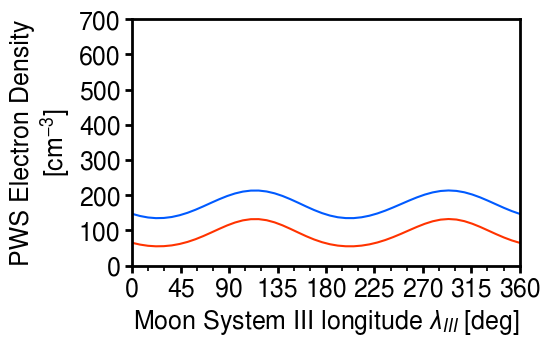

In [67]:
fsize=18
fig, ax = plt.subplots(figsize=(5,3.2), dpi=100)
ax.tick_params(axis='both', labelsize=fsize)
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0, 361, 45, dtype=int))
ax.set_xticklabels(np.arange(0, 361, 45, dtype=int))
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_ylim(0,700)
ax.set_yticks(np.linspace(0, 700, 8, dtype=int))
ax.set_yticklabels(np.linspace(0, 700, 8, dtype=int))
ax.set_xlabel('Moon System III longitude $\\lambda_{III}$ [deg]', fontsize=fsize)
ax.set_ylabel('PWS Electron Density\n[cm$^{-3}$]', fontsize=fsize)
ax.plot(np.degrees(S3wlon), (rho14/Ai)*Zi, color=cud4[0])
ax.plot(np.degrees(S3wlon), (rho22/Ai)*Zi, color=cud4[3])

plt.show()

In [68]:
print((3600/Ai)*Zi, (2000/Ai)*Zi)
print((2746/Ai)*Zi, (1703/Ai)*Zi)

280.0 155.55555555555554
213.57777777777775 132.45555555555555
